In [25]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [26]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./data/Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [27]:
serviceMediums = ["steam", "air", "liquid", "air/liquid", "na"]
mediumColors = Dict("steam" => :lightslategray, "liquid" => :mediumturquoise, "air" => :darkgoldenrod1, "air/liquid" => :limegreen, "na" => :darkmagenta)
mediumDF = Dict()
vendorDF = Dict()

for medium in serviceMediums
    mediumDF = merge(Dict(medium => filter(:Service => ==(medium), valveData)), mediumDF)
    vendorDF = merge(Dict(medium => mediumDF[medium][:, 1]), vendorDF)
end

vendorDF["steam"]

6-element Vector{String1}:
 "a"
 "c"
 "g"
 "z"
 "k"
 "m"

Set Up Model

In [28]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
    μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
    σ ~ Exponential(1) #allow possibility of large std dev in data
    
    μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ) #assume that the logit(probability) is distributed normally for each vendor
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i] #number of trials for binomial function
        p = logistic(μ[i]) #force p (probability of failure) to be 0<p<1
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p) #binomial distribution used (most appropriate since measuring probability of failure given trial data)
    end
end

valveTesting (generic function with 2 methods)

Implement Model

In [29]:
model = Dict()
posterior = Dict()
posteriorDF = Dict()
for medium in serviceMediums
  model = merge(Dict(medium => valveTesting(mediumDF[medium][:,1], mediumDF[medium][:,2], mediumDF[medium][:,3])), model)
  posterior = merge(Dict(medium => sample(model[medium], NUTS(), 1000)), posterior)
  posteriorDF = merge(Dict(medium => DataFrame(posterior[medium])), posteriorDF)
end

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.40078125000000003
└ @ Turing.Inference C:\Users\user\.julia\packages\Turing\GSvwQ\src\mcmc\hmc.jl:213
Sampling   0%|█                                         |  ETA: 0:01:22
Sampling   1%|█                                         |  ETA: 0:00:41
Sampling   1%|█                                         |  ETA: 0:00:27
Sampling   2%|█                                         |  ETA: 0:00:20
Sampling   2%|█                                         |  ETA: 0:00:16
Sampling   3%|██                                        |  ETA: 0:00:14
Sampling   3%|██                                        |  ETA: 0:00:12
Sampling   4%|██                                        |  ETA: 0:00:10
Sampling   4%|██                                        |  ETA: 0:00:09
Sampling   5%|██                                        |  ETA: 0:00:08
Sampling   5%|███                                       |  ETA: 0:00

Process Data

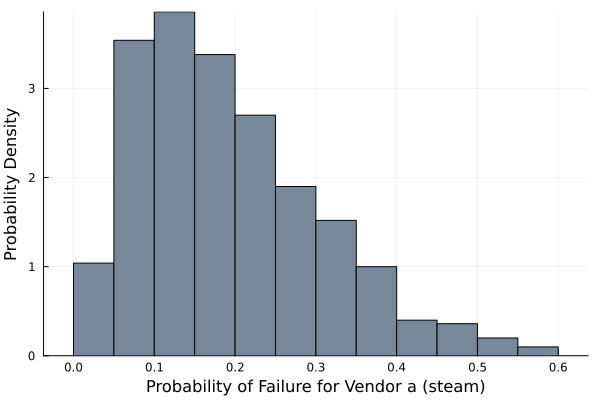

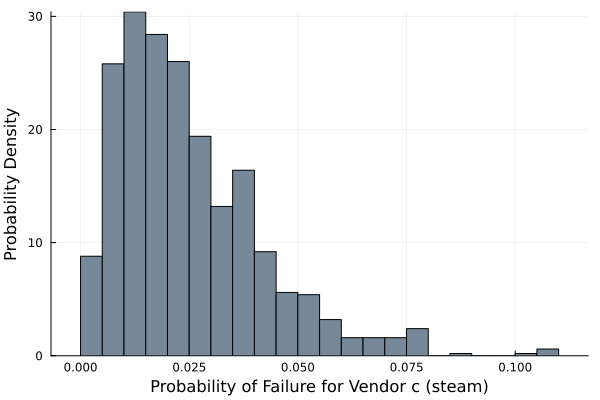

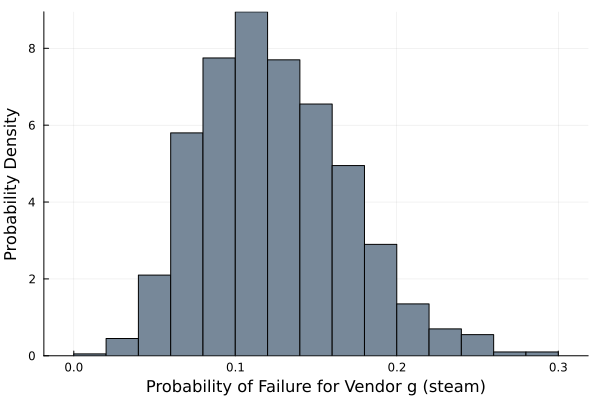

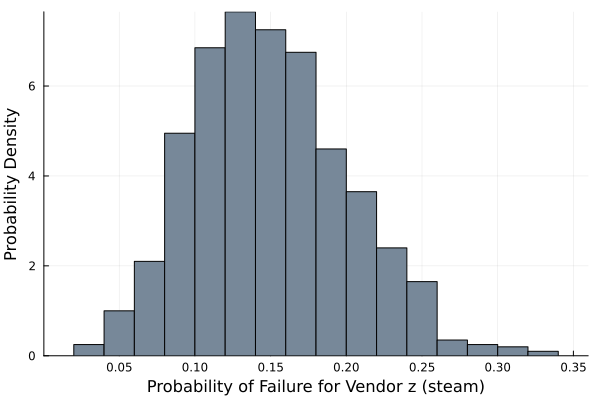

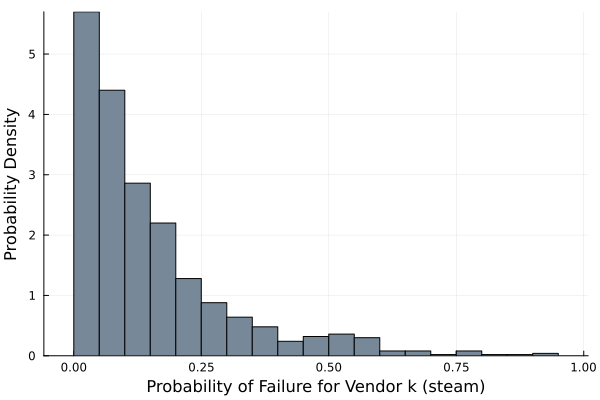

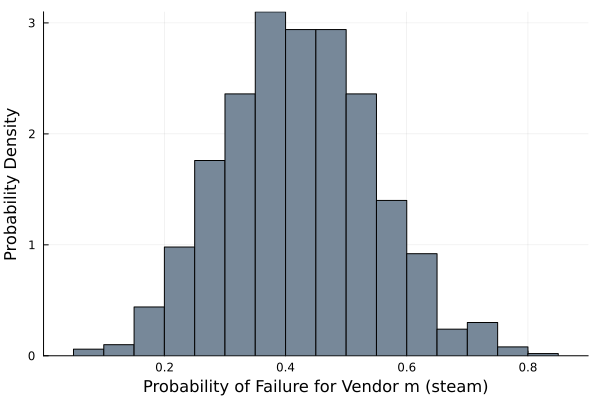

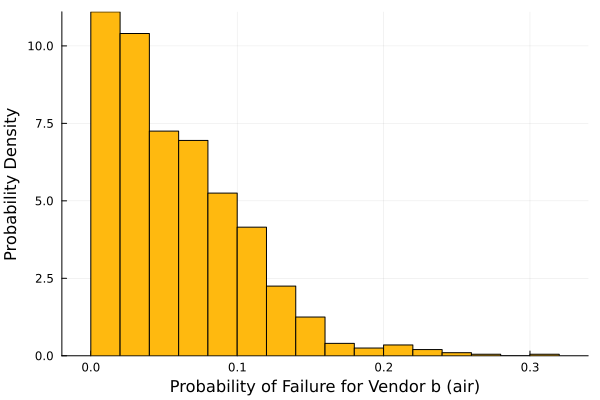

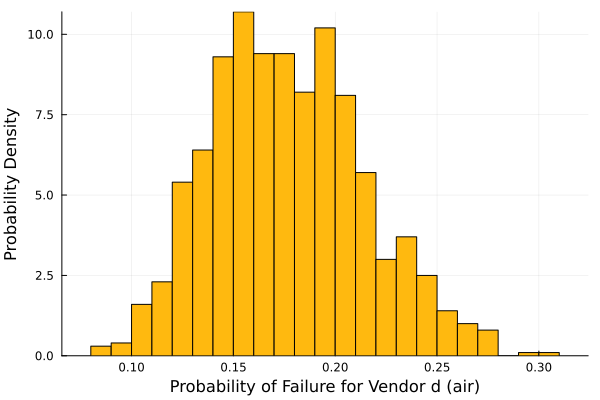

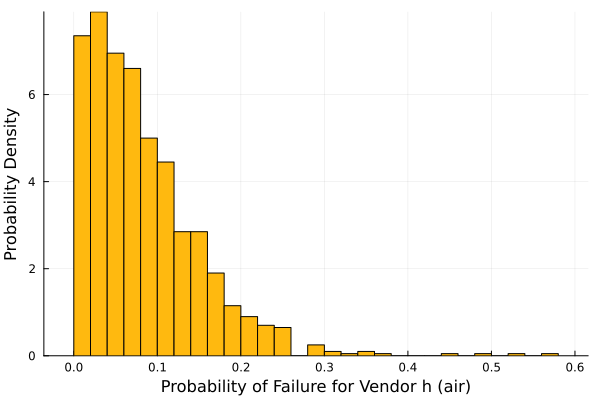

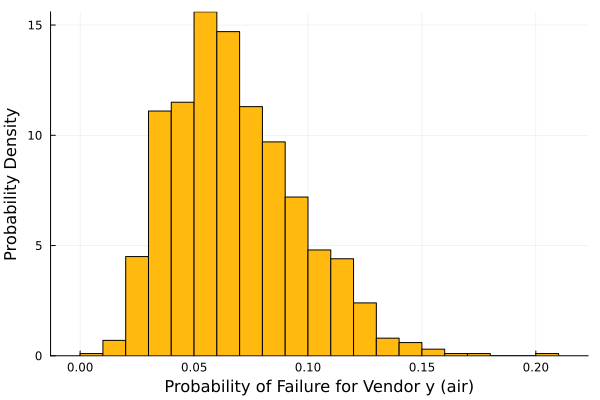

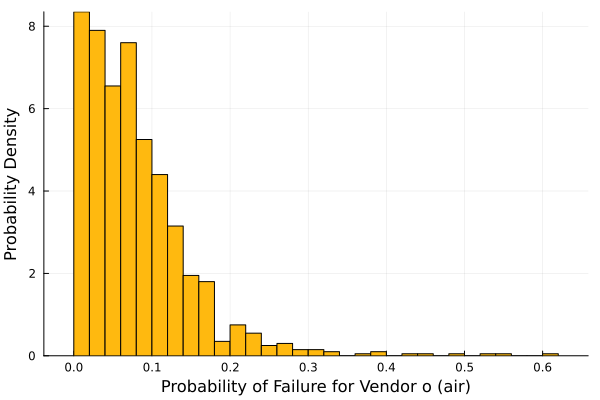

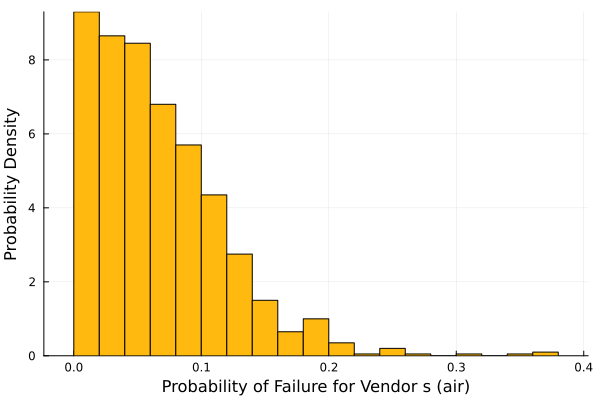

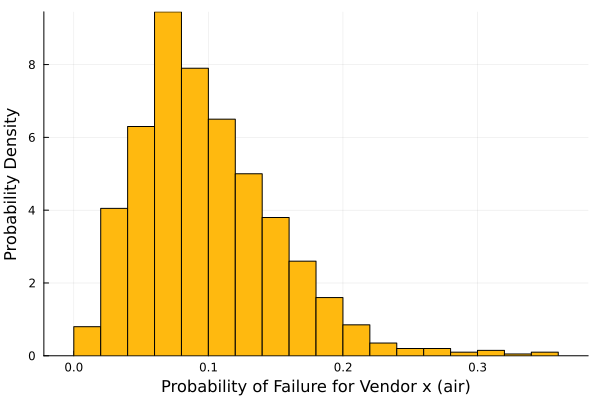

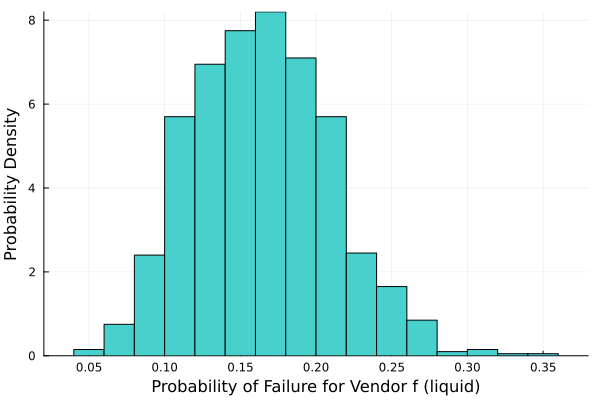

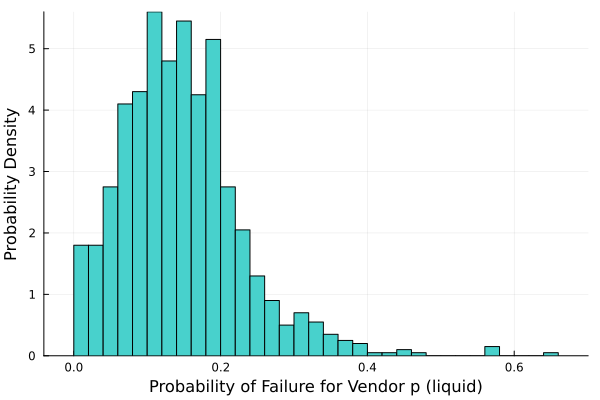

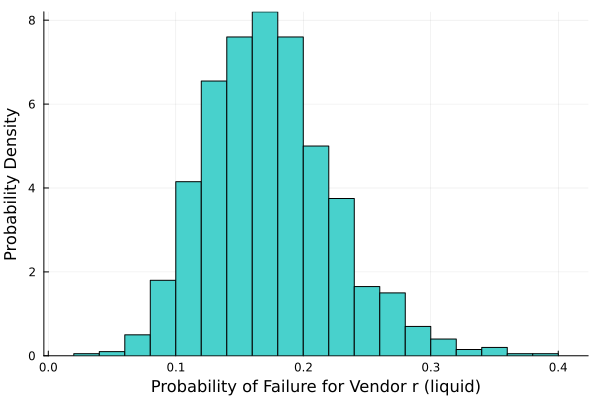

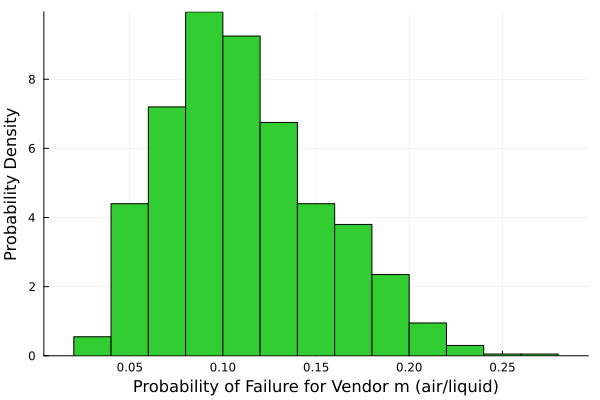

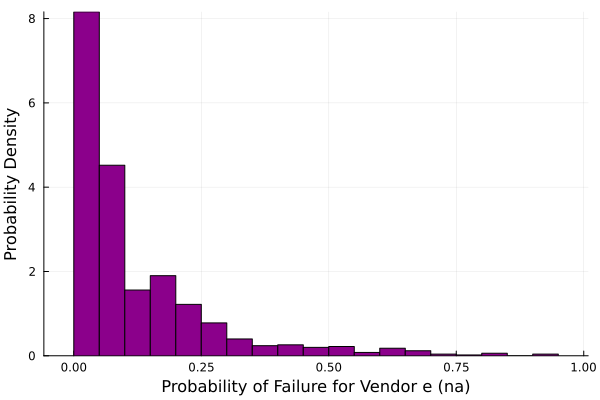

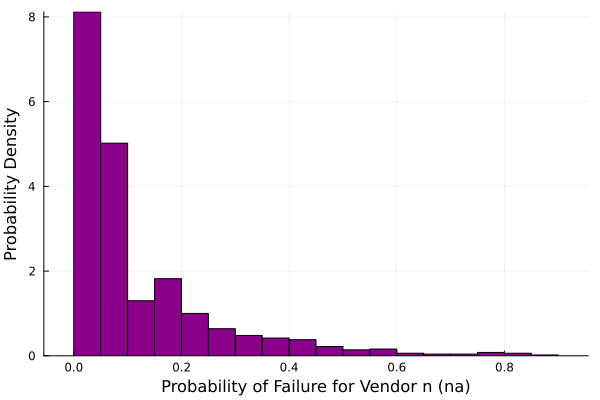

In [30]:
dataProcessed = Dict()
vendorPlots = Dict()
for medium in serviceMediums
    vendorProcessed = Dict()
    vendorMediumPlots = Dict()
    for i in 1:length(vendorDF[medium])
        #recover probability of a valve from this vendor & service medium failing an initial pop test
        vendorLog = zeros(nrow(posteriorDF[medium]))
        for j in 1:nrow(posteriorDF[medium])
            vendorLog[j] = logistic(posteriorDF[medium][j, "μ[$i]"])
        end
        vendorProcessed = merge(Dict(vendorDF[medium][i] => vendorLog), vendorProcessed)
        vendorPlot = histogram(vendorProcessed[vendorDF[medium][i]][:], xlab = "Probability of Failure for Vendor " * vendorDF[medium][i] * " (" * medium * ")", ylab = "Probability Density", normalize=:pdf, fillcolor=mediumColors[medium])
        vendorMediumPlots = merge(Dict(vendorDF[medium][i] => vendorPlot), vendorMediumPlots)
    end
    dataProcessed = merge(Dict(medium => vendorProcessed), dataProcessed)
    vendorPlots = merge(Dict(medium => vendorMediumPlots), vendorPlots)
end

#histogram(dataProcessed["steam"][vendorDF["steam"][1]], xlab = "Probability of Failure, Vendor " * vendorDF["steam"][1], ylab = "Probability Density", normalize=:pdf, bins=101)
for medium in serviceMediums
    for vendor in vendorDF[medium]
        display(plot(vendorPlots[medium][vendor], legend=false))
    end
end

Predict Valve Failure

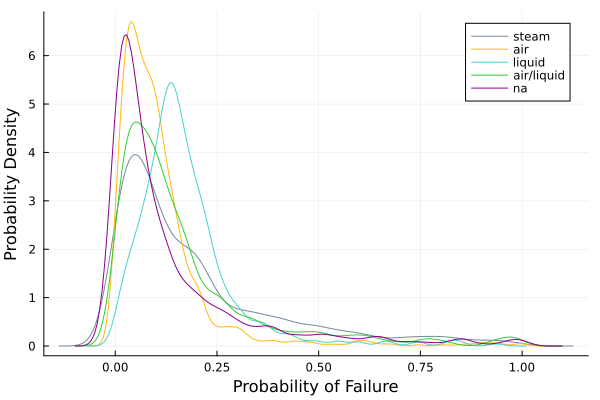

In [31]:
mediumPDF = Dict()
mediumPlots = Dict()
for medium in serviceMediums
  mediumLogodds = rand.(Normal.(posteriorDF[medium].μ_bar[1:1000], posteriorDF[medium].σ[1:1000]))
  mediumPDF = merge(Dict(medium => logistic.(mediumLogodds)), mediumPDF)
  #mediumPlots = merge(Dict( medium => density(mediumPDF[medium], linecolor=[mediumColors[medium]], label=medium)), mediumPlots)
end

# Uncomment for individual graphs
#for medium in serviceMediums
#  display(plot(mediumPlots[medium], xlab="Probability of Failure", ylab="Probability Density"))
#end

# This is for a combined graph
p = plot(xlab="Probability of Failure", ylab="Probability Density")

for medium in serviceMediums
  density!(p, mediumPDF[medium], linecolor=[mediumColors[medium]], label=medium)
end

display(p)


In [38]:
p = 0.95
quants = Dict()
modes = Dict()

for medium in serviceMediums
    vendorQuants = Dict()
    vendorModes = Dict()
    for vendor in vendorDF[medium]
        vendorQuants = merge(Dict(vendor => [quantile(dataProcessed[medium][vendor], (1-p)/2), quantile(dataProcessed[medium][vendor], (1+p)/2)]), vendorQuants)
        vendorModes = merge(Dict(vendor => mode(dataProcessed[medium][vendor])), vendorModes)
    end
    quants = merge(Dict(medium => vendorQuants), quants)
    modes = merge(Dict(medium => vendorModes), modes)
end

for medium in serviceMediums
    display(medium * " modes")
    display(modes[medium])
    display(medium * " quants")
    display(quants[medium])
end

"steam modes"

Dict{Any, Any} with 6 entries:
  String1("g") => 0.0916131
  String1("c") => 0.0753517
  String1("m") => 0.242284
  String1("k") => 0.09825
  String1("z") => 0.13634
  String1("a") => 0.0840175

"steam quants"

Dict{Any, Any} with 6 entries:
  String1("g") => [0.0477942, 0.223631]
  String1("c") => [0.00373388, 0.0685321]
  String1("m") => [0.198687, 0.665286]
  String1("k") => [0.00320481, 0.562754]
  String1("z") => [0.0613113, 0.254972]
  String1("a") => [0.0374202, 0.467907]

"air modes"

Dict{Any, Any} with 7 entries:
  String1("y") => 0.0932347
  String1("o") => 0.0880699
  String1("x") => 0.112761
  String1("b") => 0.11489
  String1("s") => 0.131942
  String1("h") => 0.105977
  String1("d") => 0.156742

"air quants"

Dict{Any, Any} with 7 entries:
  String1("y") => [0.0257601, 0.125951]
  String1("o") => [0.00345315, 0.248379]
  String1("x") => [0.0217498, 0.216844]
  String1("b") => [0.00315324, 0.164704]
  String1("s") => [0.00358201, 0.190042]
  String1("h") => [0.00328386, 0.244688]
  String1("d") => [0.112193, 0.255247]

"liquid modes"

Dict{Any, Any} with 3 entries:
  String1("f") => 0.202626
  String1("r") => 0.201291
  String1("p") => 0.14517

"liquid quants"

Dict{Any, Any} with 3 entries:
  String1("f") => [0.083311, 0.258634]
  String1("r") => [0.0899831, 0.290601]
  String1("p") => [0.0136786, 0.337932]

"air/liquid modes"

Dict{Any, Any} with 1 entry:
  String1("m") => 0.0411956

"air/liquid quants"

Dict{Any, Any} with 1 entry:
  String1("m") => [0.0411956, 0.202009]

"na modes"

Dict{Any, Any} with 2 entries:
  String1("e") => 0.0578661
  String1("n") => 0.0620567

"na quants"

Dict{Any, Any} with 2 entries:
  String1("e") => [0.00052137, 0.575293]
  String1("n") => [0.00120294, 0.515641]